In [ ]:
import numpy as np #numerical operations
import pandas as pd #data manipulation
import matplotlib.pyplot as plt #visualizations
import tensorflow as tf # provides the deep learning framework and Keras API

keras = tf.keras
layers = keras.layers #layers of NN - contains the building blocks for neural networks
Tokenizer = keras.preprocessing.text.Tokenizer #to encode the tweets - convert text into numerical sequences

from sklearn.metrics import classification_report, confusion_matrix # Evaluation with confusion matrix and classification report
import seaborn as sns


In [38]:
dset = pd.read_csv(r'C:/Users/user/Documents/Final Year Research/codespace/dataset/labeled_data.csv')
dset.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


There are 24,783 samples in this dataset and the tweets are labeled into hate statement, offensive language and neither
classes
*  0- hate speech
*  1- offensive
*  2- neutral

### preprocessing

In [39]:
dset = dset.drop(dset.columns[:5], axis=1) #removing the first 5 columns
dset.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [40]:
feature_columns = ['hate_speech','offensive', 'neutral'] # creates a list of category labels

In [41]:
# split the dataset
num_rows = len(dset.index)
train_set = round(num_rows*0.8) # 80% - training, 20% testing
train_set

train_ft = dset[0:train_set] 
test_ft = dset[train_set:]

In [42]:
train_labels=train_ft.pop('class') # Removes the class column from the dataset and saves it separately
test_labels= test_ft.pop('class')

 We want to give the model inputs (tweets) and the actual outputs (labels) separately so it can learn the connection.

In [43]:
print(train_ft.shape) # confirm everything is sized and matched properly
print(train_labels.shape)
print(test_ft.shape)
print(test_labels.shape)

(19826, 1)
(19826,)
(4957, 1)
(4957,)


### encoding words
transform tweets into integer arrays for training

In [ ]:
padding_type = 'pre' # we make all tweets the same length
max_len = 60  # words per tweet
trun_type = 'post' # If a tweet is too long, extra words will be cut from the end
oov_token = '<oov>' # out of vocab - This replaces unknown words/ out-of-vocabularies with a special token "<oov>".

tokenizer = Tokenizer(oov_token=oov_token) # Creates a tokenizer object to convert words into numbers.
tokenizer.fit_on_texts(train_ft['tweet']) # Learns all the unique words in the tweets and assigns them an indexes

vocab_size = len(tokenizer.word_index) + 1 # add 1 to fix out of bound index error
vocab_size
#tokenizer.word_index

32752

* padding_type = 'pre': make all tweets the same length, shorter ones will get zeros added to the beginning.
* max_len = 60: All tweets will be trimmed or padded to 60 words.
* trun_type = 'post':Truncate -  If a tweet is too long, extra words will be cut from the end
* oov_token = 'oov': This replaces unknown words/ out-of-vocabulary with a special token "oov"

 Machine learning models don’t understand text. This converts each tweet into a series of numbers.

In [ ]:
#convert Lables - panda df into numpy array 

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# pass the array for 3 classes
train_labels = keras.utils.to_categorical(train_labels,3)
test_labels = keras.utils.to_categorical(test_labels,3)


* Neural networks in Keras/TensorFlow expect inputs as NumPy arrays and Converting ensures compatibility with TensorFlow operations

* These lines convert integer class labels into one-hot encoded vectors, which is required for training a neural network with categorical cross-entropy loss in multi-class classification
* One-hot encoding ensures the loss is computed correctly

* helps to Understand the classification task & Calculate loss during training

In [ ]:
# encode tweets to sequences -convert raw text tweets into numerical sequences that a neural network can process 
# using the tokenizer object created before
train_ft_seq = tokenizer.texts_to_sequences(train_ft['tweet'])
test_ft_seq = tokenizer.texts_to_sequences(test_ft['tweet'])

padding the array

In [47]:
# ensure all input sequences have the same length (max_len=60) by adding padding (empty tokens) where needed
train_ft_seq = keras.utils.pad_sequences(train_ft_seq, max_len, padding=padding_type)
test_ft_seq = keras.utils.pad_sequences(test_ft_seq, max_len, padding=padding_type)

* This step is essential to prepare text data for deep learning models
* Neural networks require fixed-length inputs
* Padding standardizes all sequences to max_len=60 words

In [ ]:
# Converts the padded training sequences into a NumPy array. to ensures consistent format before feeding into the model
train_ft_seq = np.array(train_ft_seq)
test_ft_seq = np.array(test_ft_seq)
test_ft_seq.shape

(4957, 60)

### data model building

In [49]:
num_of_classes = len(feature_columns)

model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 32, input_length=max_len),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(num_of_classes, activation='softmax')
])
model.build(input_shape=(None, max_len))  

Sequential model in Keras is a linear stack of layers, where each layer has one input and one output.
* embedding layer - This layer helps the model learn semantic relationships between words
* bidirectional layer - Improves model’s understanding of the full context of a sentence, really important in language tasks
* dense layer - gives the probability distribution across the three target classes, so the model can predict the most likely category

In [ ]:
# configure/compile the model before training. 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


* It sets up how the model should update weights, calculate error, and report performance.
* Adam (Adaptive Moment Estimation). It adjusts the learning rate automatically during training
* loss function is used to measure how far the model’s predictions are from the actual labels
* accuracy to track the accuracy of the model during training

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 32)            1048064   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1064899 (4.06 MB)
Trainable params: 1064899 (4.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* Transforms text into learnable input -> Learns sequence patterns -> Outputs class probabilities

In [52]:
# train the neural network model using the prepared training data
history = model.fit(train_ft_seq, train_labels, epochs=10, verbose=2)

Epoch 1/10
620/620 - 24s - loss: 0.4495 - accuracy: 0.8463 - 24s/epoch - 39ms/step
Epoch 2/10
620/620 - 22s - loss: 0.2415 - accuracy: 0.9172 - 22s/epoch - 35ms/step
Epoch 3/10
620/620 - 21s - loss: 0.1391 - accuracy: 0.9517 - 21s/epoch - 33ms/step
Epoch 4/10
620/620 - 21s - loss: 0.0775 - accuracy: 0.9742 - 21s/epoch - 33ms/step
Epoch 5/10
620/620 - 21s - loss: 0.0447 - accuracy: 0.9864 - 21s/epoch - 33ms/step
Epoch 6/10
620/620 - 21s - loss: 0.0284 - accuracy: 0.9911 - 21s/epoch - 34ms/step
Epoch 7/10
620/620 - 21s - loss: 0.0211 - accuracy: 0.9938 - 21s/epoch - 34ms/step
Epoch 8/10
620/620 - 21s - loss: 0.0170 - accuracy: 0.9949 - 21s/epoch - 35ms/step
Epoch 9/10
620/620 - 21s - loss: 0.0151 - accuracy: 0.9953 - 21s/epoch - 34ms/step
Epoch 10/10
620/620 - 21s - loss: 0.0107 - accuracy: 0.9968 - 21s/epoch - 34ms/step


In [53]:
history.history['accuracy'][-1]

0.9968223571777344

C:\Users\user\AppData\Local\Temp\ipykernel_18180\1554956228.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


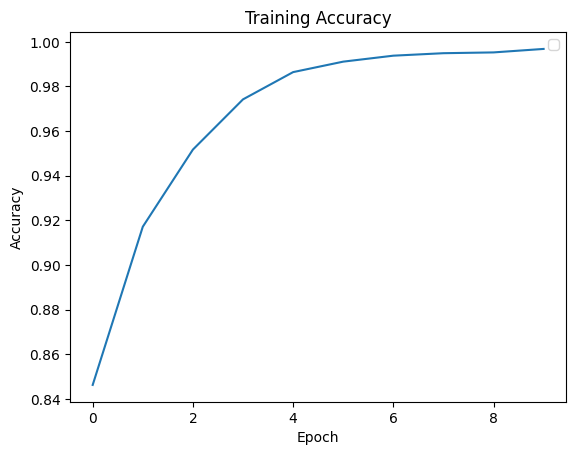

C:\Users\user\AppData\Local\Temp\ipykernel_18180\1554956228.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


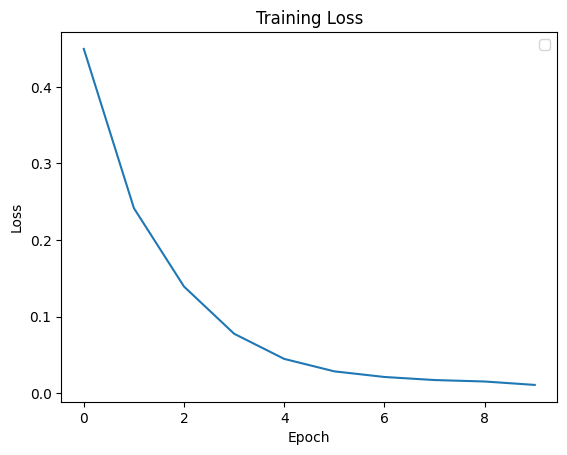

In [ ]:
#Training & loss curves
# Accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Training Accuracy')
plt.show()

# Loss
plt.figure()
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.title('Training Loss')
plt.show()

In [55]:
model.save('Keras_Hatespeech_model.h5')  # Save the model in HDF5 format

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [56]:
# Tokenize and pad the test tweets
test_sequences = tokenizer.texts_to_sequences(test_ft['tweet'])
test_padded = keras.utils.pad_sequences(test_sequences, padding='pre', truncating='post', maxlen=60)

# Predict on the full test set
pred_test = model.predict(test_padded)

pred_test_classes = np.argmax(pred_test, axis=1)
true_test_classes = np.argmax(test_labels, axis=1)

155/155 [==============================] - 2s 8ms/step


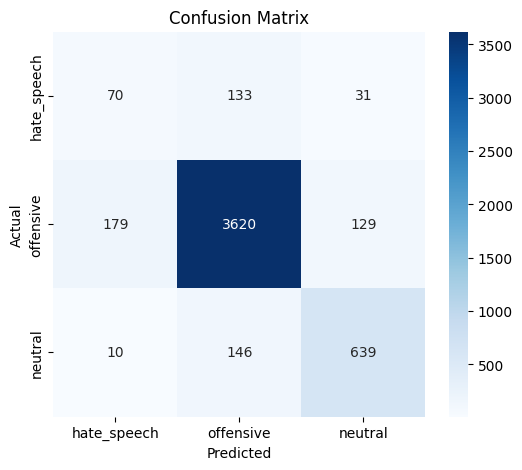

In [57]:
# Compute confusion matrix
cm = confusion_matrix(true_test_classes, pred_test_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=feature_columns, yticklabels=feature_columns)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [58]:
print("\nClassification Report:")
print(classification_report(true_test_classes, pred_test_classes, target_names=feature_columns))



Classification Report:
              precision    recall  f1-score   support

 hate_speech       0.27      0.30      0.28       234
   offensive       0.93      0.92      0.93      3928
     neutral       0.80      0.80      0.80       795

    accuracy                           0.87      4957
   macro avg       0.67      0.67      0.67      4957
weighted avg       0.88      0.87      0.87      4957



### predict a comment 

To demonstrate real-time applicability, here added stand-alone inference pipeline to
show real-time applicability.

In [59]:
import json

with open('hate_comment_detection.json','w') as file:
    json.dump(tokenizer.word_index, file)

In [60]:
with open('hate_comment_detection.json','r') as file:
    data = json.load(file)

word_index = dict(data)

In [61]:
#random_tweet = 'I love you'
random_tweet = 'I really wanna kill you'
#random_tweet = 'just die. you whore'

oov_token = '<oov>'

tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.word_index = word_index
encoded = tokenizer.texts_to_sequences([random_tweet])
encoded = keras.utils.pad_sequences(encoded, padding='pre', truncating='post',maxlen=60)


In [62]:
pred_new = model.predict(encoded)

1/1 [==============================] - 0s 34ms/step


In [63]:
print("Predicted probabilities:", pred_new[0])
print("Highest confidence score:", np.max(pred_new[0]))
print("Predicted class index:", np.argmax(pred_new[0]))
print("Predicted class label:", feature_columns[np.argmax(pred_new[0])])


Predicted probabilities: [0.5475154 0.2270443 0.2254403]
Highest confidence score: 0.5475154
Predicted class index: 0
Predicted class label: hate_speech
